# SRGAN

This notebook is a simple implementation of the SRGAN super resolution architecture. Further Improvements need to be done. 

### Key takeaways from the paper

- Ability of Mean Squared Error, Peak Signal to Noise Ratio to capture 'perceptually relevant'(like texture for instance) differences like high texture details is limited as both are based on pixel wise image differences. 

- Super resolved image may not be as photo realistic as the original image. 

- A Super Resolution Generative Adversarial Network is proposed, in which a deep residual network(ResNet) with skip connections. 

- A novel loss function is also proposed which uses high level feature maps of the VGG network. 

- Low resolution images were obtained by applying a Gaussian filter to the High Resolution Image, proceeded by a downsampling with a factor of r. 

- The ParametricReLU is used as the activation function. 

- The perceptual loss function was defined as a sum of content loss and adversarial loss. Weightage of the loss function is $1 : \frac{1}{1000}$(content loss : adversarial loss)

- Perceptual Loss > can use many humans to eval images, a far practical method is to use a pre trained network that has been trained on millions of images.

#### Things to read up on:
- MSE, PSNR 
- ResNet, skip connections
- Loss functions
- feature maps, vgg network

## Dependencies

In [1]:
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join
from torch import nn, optim
from torchvision.models.vgg import vgg16
from tqdm import tqdm
import os
from time import time
torch.autograd.set_detect_anomaly(True)

In [2]:
import warnings as wr
wr.filterwarnings("ignore")

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Dataset

This section contains code for the dataloader needed for the data in the folder. This is a custom implementation of the `TrainDatasetFromFolder` class, which inherits from the original class in the `pytorch` library. The dataloader returns a HR(High Resolution, which is the image at its original resolution) image and an LR image(which has been resized to introduce image degradation).

The dataset we used in this notebook is the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset, which contains 1000 images of 2K resolution(800 training images, 100 validation images, 100 testing images)

In [6]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

In [7]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

In [8]:
def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])

In [9]:
def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

In [10]:
def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

In [11]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [12]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=0, shuffle=True)

# Model Implementation

![SRGAN Model Architecture](srgan.png)

## Generator Architecture

The first major block consists of a sequence of residual blocks, after the input layer. 

### What is a Residual Block?

A Residual block consists of the following components:
- A series of convolutional layers that are responsible for extracting features from the input data. 
- Batch normalisation is applied after each convolutional layer. This helps in stabilising and accelerating training by normalising the input to the following layer. 
- Activation functions are applied to introduce non linearity in the network, which allows the network to learn complex and non linear patterns in the data. 
- Skip Connection is essentially the sum of the input of the block and the output of the last batch normalisation layer, allows gradients to flow more freely throught the network. 

> Note: Read up on the Vanishing Gradient Problem

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

The next block in the generator is the upscaling block. The upsaming block is comprises of an initial convolution layer, which feeds into a pixel shuffle layer, and then lastly fed into a ParametricReLU activation function. 

In [14]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                              kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [15]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        super(Generator, self).__init__()
        upsample_block_num = int(math.log(scale_factor, 2))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        return (torch.tanh(block8) + 1) / 2

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
    def forward(self, x):
        batch_size=x.size()[0]
        return torch.sigmoid(self.net(x).view(batch_size))

## Loss Functions

A number of loss functions have been devised over the past years to train SR models. These can be categorised into 2 categories: 

1. Pixel Based Losses
2. Network Based Lossed

#### Pixel Based Losses

- Pixel Loss(MSE): This is Mean Squared Error, in which each pixel of the SR image is compared against the corresponding pixel in the HR image. 
- Mean Absolute Error: This is the sum of the absolute difference between the predicted values of the model and the actual target values. 
- Total Variation Loss(TV): This method is used to supress the noise in the generated image. It measures the noise in the image by taking the absolute difference between neighbouring pixels. 

#### Network Based Losses

- Perceptual Losses: This loss function evaluates based on the perceptual quality of the generated SR image as compared to the perceptual quality of the HR image. The way this is implemented is using the high level features of a pretrained image classification network. 
- Texture Loss: This loss function is used to enable the generated SR image to have the same style as the HR image(can include texture, colour, contrast in the image). 
- Adversarial Loss: In essence this is the min-max loss function. The generator tries to maximise, while the discriminator tries to minimise. 

### The SRGAN Loss function 

The paper proposed a perceptual loss function, which consists of an adversarial loss and a content loss. The content loss is useful for comparing the features of the reconstructed images with the original images, focusing on differences in features rather than differences in pixel levels in attributes like colour and brightness. <br>

In addition, the SRGAN model uses the VGG19 network to extract image features for content loss calculation. The VGG19 convolutional neural network was developed by Karen Simoyan and Andrew Zisserman at the University of Oxford in 2014. The network contains 19 trainable networks, out of which, 16 of those layers are convolutional. The network relies on 3x3 convolutions with a stride of 1(Stride refers to the number of pixels by which we move the filter/kernel across the input image).<br>

By utilising  the VGG19 network, the SRGAN model can extract complex features from images and compare them to enhance image quality. Additionally, the VGG loss helps in preserving high frequency information and fine details in the reconstructed images. The adversarial loss function in the SRGAN model also encourages the generator to produce images that closely resemble high resolution images, further enhancing the overall performance of the model. <br>

As stated earlier, the perceptual loss function consists of an adverserial loss and a content loss. The equation for them is given below. 


$$\large l^{\text{SR}} = \overbrace{\underbrace{l_x^{\text{SR}}}_{\text{Content Loss}} + \underbrace{10^{-3}l_{\text{Gen}}^{\text{SR}}}_{\text{Adversarial Loss}}}^{\text{Perceptual Loss}} $$

As we can see from the equation, the content loss plays a major role in the loss function of the SRGAN loss function, while the adversarial loss function only has $\frac{1}{1000}$th of weightage in the loss function. <br>

The content loss is composed of 2 parts, MSE Loss, and VGGLoss. The MSE Loss is the pixel wise error between the HR image and the SR image, whereas the VGG loss indicates the feature map obtained by the j-th convolution(post activation) before the i-th maxpooling layer within the VGG19 network. This is also defined as the euclidean distance between the feature representations of a reconstructed image and the reference image. 

The `TVLoss` Class defined below calculates Total Variable Loss, which measures the smoothness of a tensor, by encouranging small differences between neighbouring pixels. Horizontal and vertical variations are also considered, and a single loss value is returned. 

In [17]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight=tv_loss_weight
  
    def forward(self, x):
        batch_size=x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])

        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod # Must add this
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

The `GeneratorLoss` Class is where we have initialised the loss function of the model. This contains of various parts: 
- `vgg`: The pretrained VGG-16 network, which is a CNN used for image recognition. The `pretrained=True` arguments means that the weights of the network are initialised with the weights trained on the ImageNet dataset. 
- `loss_network`: This is a subnetwork of the VGG network, containing the first 31 layers of the network. This subnet is used to calculate the perception loss. 
- `mse_loss`: This is the MSE loss function, used to compare generated images with target images. 
- `tv_loss`: This is the total variation loss used to smooth out the generated images

In [18]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
          param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
        
    def forward(self, out_labels, out_images, target_images):
        adversial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(out_images, target_images)
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

### Device Selection

This next code cell initialises the device that will be used for training. Since this is trained on a local machine, the model will choose a CUDA capable device(in this case, a Mobile NVIDIA RTX 3070Ti GPU with 8GB of VRAM). 

In [19]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [21]:
generator_criterion = GeneratorLoss()

In [22]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [23]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [24]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [25]:
N_EPOCHS = 150 

In [26]:
def saveCheckpoint(model, optimizer, filename):
    print('===> saving checkpoint')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint,filename)

In [31]:
def loadCheckpoint(checkpoint_file, model, optimizer, lr): 
    print('===> load checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    for param_group in optimizer.param_groups:      # needed or model will have learning rate of older checkpoint 
        param_group['lr'] = lr

The Code block below implements the training of the SRGAN model. The discriminator network is updated first, followed by the generator network. The process is repeated for each batch of data until the end of the epoch is reached. The running totals of the losses and scores are used to compute the average loss and score for each epoch. 

In [27]:
from time import time
t0 = time()
for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(trainloader)
    running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}
    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        fake_img = netG(z)
        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += real_out.item() * batch_size

        ## Updating the progress bar
        train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
            epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']
        ))
    results['d_loss'].append(running_results['d_loss'])
    results['g_loss'].append(running_results['g_loss'])
    results['d_score'].append(running_results['d_score'])
    results['g_score'].append(running_results['g_score'])
    
    if epoch%50==0:
        saveCheckpoint(netG, optimizerG, filename='checkpoints/generator_checkpoint.pth')
        print(f'Saved Generator Checkpoint')
        saveCheckpoint(netD, optimizerD, filename='checkpoints/discriminator_checkpoint.pth')
        print(f'Saved Discriminator Checkpoint')
    netG.eval()
print(f'Total Training Time: {(t0 - time())/3600} Hours')

[1/150] Loss_D: 0.7855 Loss_G: 0.0405 D(x): 0.6106 D(G(z)): 0.6106: 100%|██████████████| 13/13 [01:45<00:00,  8.09s/it]
[2/150] Loss_D: 0.6498 Loss_G: 0.0169 D(x): 0.6921 D(G(z)): 0.6921: 100%|██████████████| 13/13 [01:26<00:00,  6.69s/it]
[3/150] Loss_D: 0.4004 Loss_G: 0.0149 D(x): 0.8199 D(G(z)): 0.8199: 100%|██████████████| 13/13 [01:33<00:00,  7.22s/it]
[4/150] Loss_D: 0.1510 Loss_G: 0.0125 D(x): 0.9156 D(G(z)): 0.9156: 100%|██████████████| 13/13 [01:36<00:00,  7.42s/it]
[5/150] Loss_D: 0.0780 Loss_G: 0.0112 D(x): 0.9667 D(G(z)): 0.9667: 100%|██████████████| 13/13 [01:47<00:00,  8.28s/it]
[6/150] Loss_D: 0.1372 Loss_G: 0.0105 D(x): 0.9071 D(G(z)): 0.9071: 100%|██████████████| 13/13 [01:29<00:00,  6.89s/it]
[7/150] Loss_D: 0.6421 Loss_G: 0.0105 D(x): 0.6534 D(G(z)): 0.6534: 100%|██████████████| 13/13 [02:16<00:00, 10.49s/it]
[8/150] Loss_D: 0.9256 Loss_G: 0.0095 D(x): 0.6989 D(G(z)): 0.6989: 100%|██████████████| 13/13 [01:40<00:00,  7.75s/it]
[9/150] Loss_D: 0.4261 Loss_G: 0.0093 D(

===> saving checkpoint
Saved Generator Checkpoint
===> saving checkpoint
Saved Discriminator Checkpoint


[51/150] Loss_D: 0.0012 Loss_G: 0.0053 D(x): 0.9994 D(G(z)): 0.9994: 100%|█████████████| 13/13 [01:37<00:00,  7.47s/it]
[52/150] Loss_D: 0.0010 Loss_G: 0.0052 D(x): 0.9994 D(G(z)): 0.9994: 100%|█████████████| 13/13 [01:29<00:00,  6.90s/it]
[53/150] Loss_D: 0.0008 Loss_G: 0.0057 D(x): 0.9998 D(G(z)): 0.9998: 100%|█████████████| 13/13 [01:37<00:00,  7.48s/it]
[54/150] Loss_D: 0.0011 Loss_G: 0.0059 D(x): 0.9994 D(G(z)): 0.9994: 100%|█████████████| 13/13 [01:40<00:00,  7.76s/it]
[55/150] Loss_D: 0.0008 Loss_G: 0.0054 D(x): 0.9996 D(G(z)): 0.9996: 100%|█████████████| 13/13 [01:26<00:00,  6.69s/it]
[56/150] Loss_D: 0.0007 Loss_G: 0.0058 D(x): 0.9996 D(G(z)): 0.9996: 100%|█████████████| 13/13 [01:37<00:00,  7.50s/it]
[57/150] Loss_D: 0.0004 Loss_G: 0.0054 D(x): 0.9999 D(G(z)): 0.9999: 100%|█████████████| 13/13 [01:22<00:00,  6.36s/it]
[58/150] Loss_D: 0.0009 Loss_G: 0.0052 D(x): 0.9996 D(G(z)): 0.9996: 100%|█████████████| 13/13 [01:38<00:00,  7.58s/it]
[59/150] Loss_D: 0.0006 Loss_G: 0.0057 D

===> saving checkpoint
Saved Generator Checkpoint
===> saving checkpoint
Saved Discriminator Checkpoint


[101/150] Loss_D: 0.0809 Loss_G: 0.0051 D(x): 0.9498 D(G(z)): 0.9498: 100%|████████████| 13/13 [01:49<00:00,  8.40s/it]
[102/150] Loss_D: 0.1060 Loss_G: 0.0048 D(x): 0.9704 D(G(z)): 0.9704: 100%|████████████| 13/13 [01:34<00:00,  7.24s/it]
[103/150] Loss_D: 0.0211 Loss_G: 0.0049 D(x): 0.9855 D(G(z)): 0.9855: 100%|████████████| 13/13 [01:33<00:00,  7.19s/it]
[104/150] Loss_D: 0.0042 Loss_G: 0.0049 D(x): 0.9989 D(G(z)): 0.9989: 100%|████████████| 13/13 [01:28<00:00,  6.79s/it]
[105/150] Loss_D: 0.0050 Loss_G: 0.0049 D(x): 0.9979 D(G(z)): 0.9979: 100%|████████████| 13/13 [01:30<00:00,  6.94s/it]
[106/150] Loss_D: 0.0059 Loss_G: 0.0047 D(x): 0.9952 D(G(z)): 0.9952: 100%|████████████| 13/13 [01:31<00:00,  7.02s/it]
[107/150] Loss_D: 0.0068 Loss_G: 0.0045 D(x): 0.9932 D(G(z)): 0.9932: 100%|████████████| 13/13 [01:38<00:00,  7.55s/it]
[108/150] Loss_D: 0.0006 Loss_G: 0.0047 D(x): 0.9997 D(G(z)): 0.9997: 100%|████████████| 13/13 [01:29<00:00,  6.90s/it]
[109/150] Loss_D: 0.0096 Loss_G: 0.0047 

===> saving checkpoint
Saved Generator Checkpoint
===> saving checkpoint
Saved Discriminator Checkpoint
Total Training Time: -3.9544782521327337 Hours


# An attempt at testing the model

In [37]:
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from scipy.ndimage import rotate
import sys
from math import log10, sqrt 
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2
import torchvision.transforms as transforms
from scipy.ndimage import rotate
from time import time
import warnings as wr
wr.filterwarnings("ignore")

In [29]:
def testModel(input_file, save_image=False):
    '''
    This function passes an image into the model, and retrieves its input. 
    Need to implement model saving and checkpointing. 
    '''
    # Read input image and convert to Tensor for feeding into model
    image = cv2.imread(input_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Need to add this as OpenCV uses BGR instead of RGB
    transform = transforms.Compose([transforms.ToTensor()])
    in_tensor = transform(image)
    
    # Feed input tensor into model
    in_tensor = in_tensor.to(device) # Send input to device, can cause problems if input tensor is on CPU and Model on GPU!!
    out_tensor = netG(in_tensor.unsqueeze(0))
    
    # Final transformations, as for some reason, output is rotated
    display_tensor = out_tensor.to('cpu') # send output tensor back to CPU
    display_tensor = display_tensor.detach().numpy()
    display_tensor = np.transpose(display_tensor)
    display_tensor = np.squeeze(display_tensor)
    display_tensor = cv2.flip(display_tensor, 0)
    display_tensor = rotate(display_tensor, -90)
    f = (display_tensor * 255).astype(np.uint8) # Normalise the image
    
    if save_image:  
        out_file = input('What name do you want to save the image as: ')
        cv2.imwrite(f'{out_file}.png', f)
    
    return display_tensor

In [34]:
def PSNR(i, j): 
    mse = np.mean((i - j) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [35]:
def MSE(i, j):
    # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
    mse_error = np.sum((i.astype("float") - j.astype("float")) ** 2)
    mse_error /= float(i.shape[0] * i.shape[1])
    # return the MSE. The lower the error, the more "similar" the two images are.
    return mse_error

In [36]:
def SSIM(i,j):
    i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    j = cv2.cvtColor(j, cv2.COLOR_BGR2GRAY)
    s = ssim(i, j)
    return s

ValueError: operands could not be broadcast together with shapes (656,528,3) (656,529,3) 

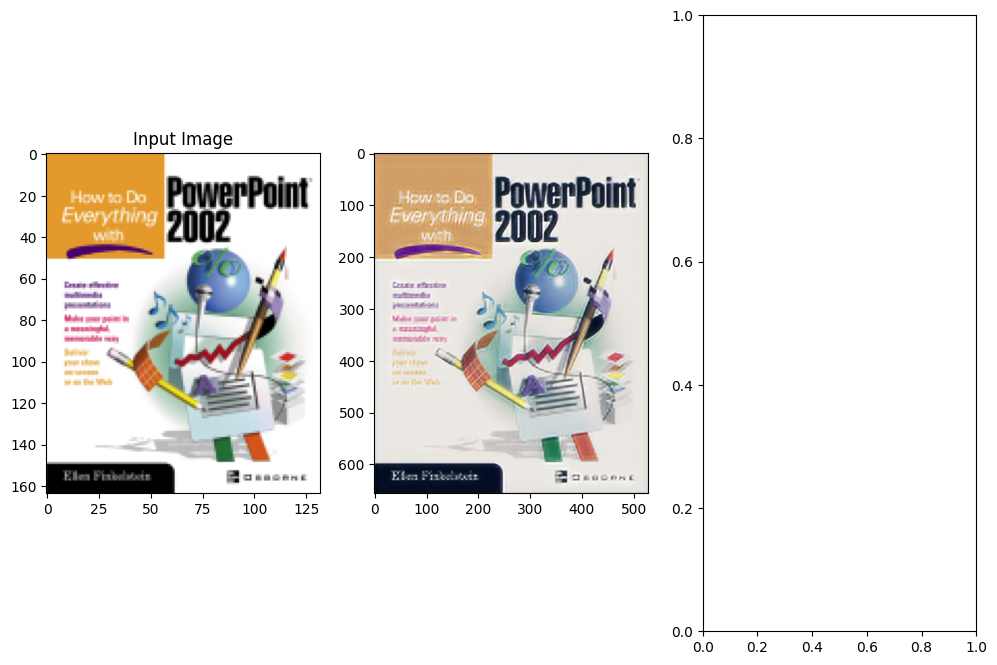

In [39]:
a = testModel('source/test_images/ppt3_test.png')

i = cv2.imread('source/test_images/ppt3_test.png')
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)

j = cv2.imread('source/test_images/ppt3.png')
j = cv2.cvtColor(j, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(12,8))
ax[0].imshow(i)
ax[0].set_title(f'Input Image')
ax[1].imshow(a)
ax[1].set_title(f'Output Image\nPSNR: {PSNR(a,j):.3f}, SSIM: {SSIM(a,j):.3f}')
ax[2].imshow(j)
ax[2].set_title(f'HR Image')

Text(0.5, 1.0, 'Output Image')

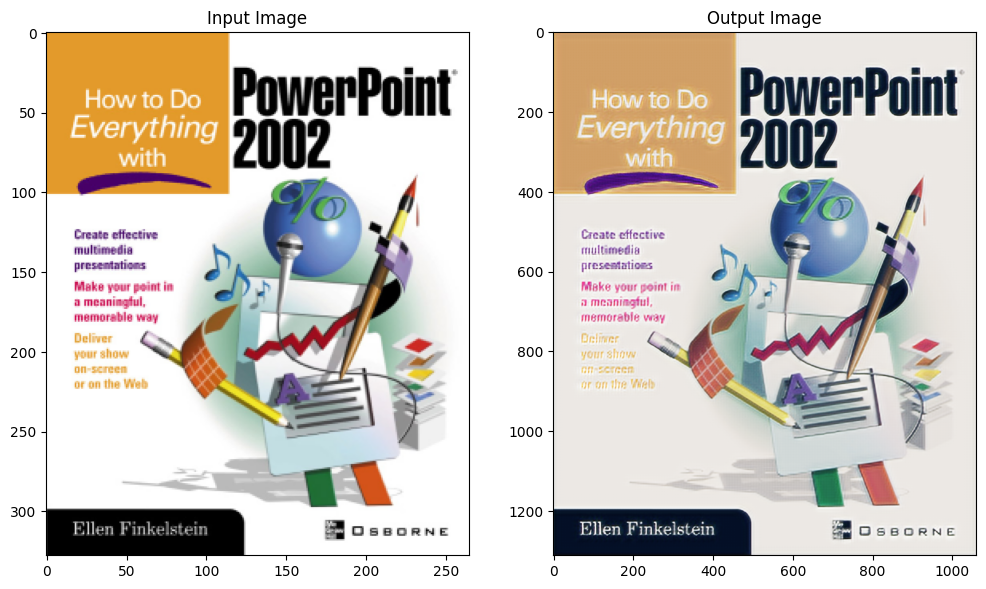

In [33]:
a = testModel('source/test_images/ppt3_test.png')
i = cv2.imread('source/test_images/ppt3_test.png')
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(i)
ax[0].set_title('Input Image')
ax[1].imshow(a)
ax[1].set_title('Output Image')

Text(0.5, 1.0, 'Output Image')

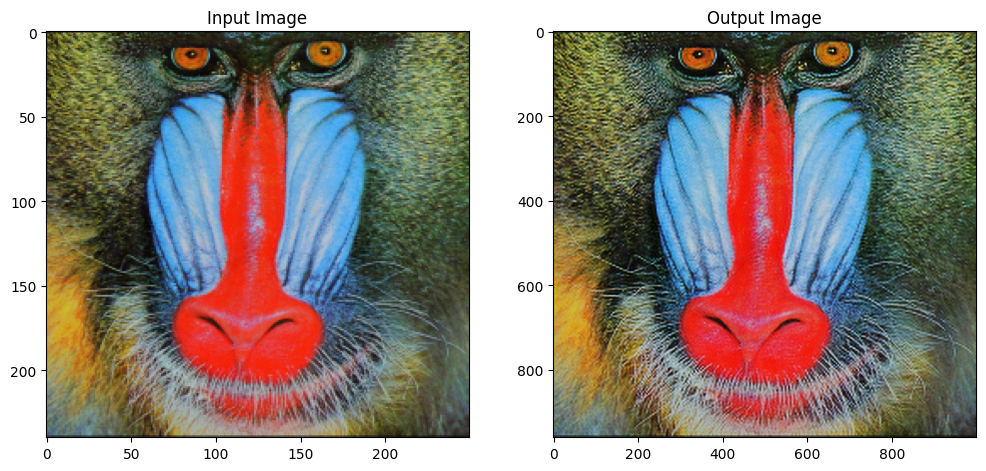

In [46]:
a = testModel('source/test_images/baboon_test.png')
i = cv2.imread('source/test_images/baboon_test.png')
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(i)
ax[0].set_title('Input Image')
ax[1].imshow(a)
ax[1].set_title('Output Image')

Text(0.5, 1.0, 'Discriminator vs Generator Loss')

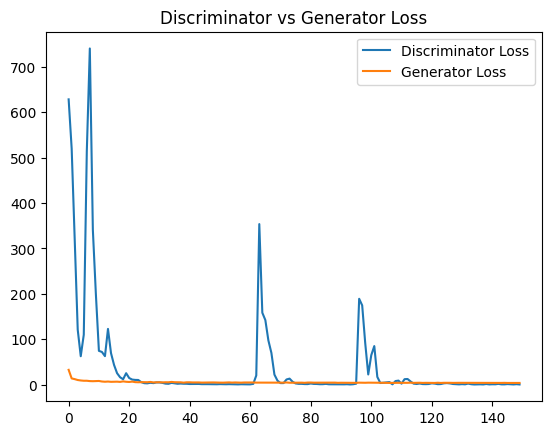

In [44]:
plt.plot(results['d_loss'], label='Discriminator Loss')
plt.plot(results['g_loss'], label='Generator Loss')
plt.legend()
plt.title('Discriminator vs Generator Loss')

In [32]:
loadCheckpoint('checkpoints/generator_checkpoint.pth', netG, optimizerG, 0.0002)
loadCheckpoint('checkpoints/discriminator_checkpoint.pth', netD, optimizerD, 0.0002)

===> load checkpoint
===> load checkpoint
